______________________________________________________________________________________________________
This notebook contains a simple variational autoencoder. 

The following resources have been helpful:
* https://arxiv.org/pdf/1606.05908v2.pdf
* https://jmetzen.github.io/2015-11-27/vae.html
_______________________________________________________________________________________________________

# Setup

In [1]:
# load MNIST data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/mnist', one_hot=False)

"""start TensorFlow InteractiveSession - connects to C++ backend
The common usage for TensorFlow programs is to first create a 
graph and then launch it in a session. Here we instead use the 
convenient 'InteractiveSession' class, which makes TensorFlow
more flexible about how you structure the code. It allows you to
interleave operations which build a computation graph with ones
that run the graph."""
sess = tf.InteractiveSession()

np.random.seed(0)
tf.set_random_seed(0)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


# Build a Multilayer Network

## Helper Functions

In [2]:
# create functions to initialize weights and biases

# no negative weights since we'll be using ReLUs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# constant initial biases are fine
def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)


## Initialize Model Parameters

In [70]:
# define model params
layers_enc = [784, 400, 400]
num_lvs = 20
layers_dec = [num_lvs, 400, 400, 784]

num_layers_enc = len(layers_enc)
num_layers_dec = len(layers_dec)

# create placeholders for input and random noise
x = tf.placeholder(tf.float32, shape=[None, layers_enc[0]])
eps = tf.placeholder(tf.float32, shape=[None, num_lvs])
# note that the 'shape' argument to placeholder is optional, 
# but it allows for error-checking

# initialize weights and biases in encoding model
weights_enc = []
biases_enc = []
for i in range(num_layers_enc-1):
    weights_enc.append(weight_variable([layers_enc[i], layers_enc[i+1]]))
    biases_enc.append(bias_variable([layers_enc[i+1]]))
    
# initialize weights and biases in decoding model
weights_dec = []
biases_dec = []
for i in range(num_layers_dec-1):
    weights_dec.append(weight_variable([layers_dec[i], layers_dec[i+1]]))
    biases_dec.append(bias_variable([layers_dec[i+1]]))

# intialize weights for means and std
weights_mean = weight_variable([layers_enc[-1], num_lvs])
biases_mean = bias_variable([num_lvs])
weights_log_var = weight_variable([layers_enc[-1], num_lvs])
biases_log_var = bias_variable([num_lvs])

## Define Model Structure

In [72]:
# push data through the encoding function to determine mean and std
# of latent vars
z_enc = [];
for i in range(num_layers_enc):
    if i == 0:
        z_enc.append(x);
    else:
        z_enc.append(tf.nn.relu(tf.add(tf.matmul(z_enc[i-1], weights_enc[i-1]), \
                     biases_enc[i-1])))

z_mean = tf.add(tf.matmul(z_enc[-1], weights_mean), biases_mean)
# estimating log of the variance is easier since the latent loss has
# a log determinant term
z_log_var = tf.add(tf.matmul(z_enc[-1], weights_log_var), biases_log_var)

# push data through the decoding function to reconstruct data
z_dec = [];
for i in range(num_layers_dec):
    if i == 0:
        # z = mu + sigma*epsilon
        z_dec.append(tf.add(z_mean, 
                     tf.mul(eps, tf.sqrt(tf.exp(z_log_var)))))
    else:
        z_dec.append(tf.nn.relu(tf.add(tf.matmul(z_dec[i-1], weights_dec[i-1]), \
                     biases_dec[i-1])))
        
x_recon = z_dec[-1]

## Specify Loss Function and Training

In [73]:
# define reconstruction loss
loss_recon = 0.5*tf.reduce_sum(tf.square(z_dec[-1] - x), 1)

# define latent loss
loss_latent = 0.5*tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 
                                num_lvs - z_log_var, 1)

# define cost
cost = tf.reduce_mean(loss_recon + loss_latent)

# define one step of the optimization routine
train_step = tf.train.AdamOptimizer(1e-3).minimize(cost)

## Train Model

In [74]:
batch_size = 100;
train_iters = 20000;
output_iters = 1000;

# intialize all variables
sess.run(tf.initialize_all_variables())

# train
for i in range(train_iters):
    # get batch of data for this training step
    batch = mnist.train.next_batch(batch_size)
    
    # Draw samples from Gaussian distribution
    eps_ = np.random.randn(batch_size, num_lvs)
    # eps_ = tf.random_normal((batch_size, num_lvs), 0, 1, dtype=tf.float32)

    # print training updates
    if i % output_iters == 0:
        train_accuracy = cost.eval(feed_dict={x: batch[0], eps: eps_})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    # one step of optimization routine
    train_step.run(feed_dict={x: batch[0], eps: eps_})
   


step 0, training accuracy 104.357
step 1000, training accuracy -164.9
step 2000, training accuracy -164.522
step 3000, training accuracy -167.045
step 4000, training accuracy -166.863
step 5000, training accuracy -166.722
step 6000, training accuracy -168.188
step 7000, training accuracy -168.763
step 8000, training accuracy -168.694
step 9000, training accuracy -168.294
step 10000, training accuracy -168.288
step 11000, training accuracy -168.239
step 12000, training accuracy -167.138
step 13000, training accuracy -169.249
step 14000, training accuracy -169.261
step 15000, training accuracy -169.026
step 16000, training accuracy -168.619
step 17000, training accuracy -170.38
step 18000, training accuracy -170.274
step 19000, training accuracy -169.469
step 20000, training accuracy -169.522
step 21000, training accuracy -169.131
step 22000, training accuracy -168.951
step 23000, training accuracy -170.327
step 24000, training accuracy -169.76
step 25000, training accuracy -170.082
step

# Visualize Model

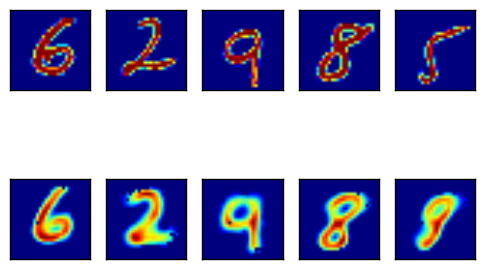

In [81]:
batch = mnist.train.next_batch(batch_size)
# eps_ = np.random.randn(batch_size, num_lvs)   
eps_ = np.zeros((batch_size, num_lvs))
recon = x_recon.eval(feed_dict={x: batch[0], eps: eps_})

f, ax = plt.subplots(2,5)
for j in range(5):
    ax[0,j].imshow(np.reshape(batch[0][j,:], (28, 28)))
    ax[0,j].axes.get_xaxis().set_visible(False)
    ax[0,j].axes.get_yaxis().set_visible(False)
    
    ax[1,j].imshow(np.reshape(recon[j,:], (28, 28)))
    ax[1,j].axes.get_xaxis().set_visible(False)
    ax[1,j].axes.get_yaxis().set_visible(False)

plt.show()

In [ ]:
#TODO
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()